In [1]:
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit1.txt
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit2.txt
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit3.txt
!pip3 install odeintw

--2022-07-28 13:40:23--  https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘circuit1.txt’

circuit1.txt        100%[===================>]      71  --.-KB/s    in 0s      

2022-07-28 13:40:23 (3.53 MB/s) - ‘circuit1.txt’ saved [71/71]

--2022-07-28 13:40:23--  https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt
import random as rm
import odeintw as ow

In [3]:
def str_on_edge(a,b,c,d):
    s = ''
    if not a == 0 :
       s = s + str(a) + 'Ohms '
    if not b == 0 :
       s = s + str(b) + 'Volts '
    if not c == 0 :
       s = s + str(c) + 'Farad '
    if not d == 0 :
       s = s + str(d) + 'Henry '
    return s

In [4]:
def print_sug_dir(vals):
    for val in vals :
        s = '[' + str(val[0]) + ']' + '---->' + '[' + str(val[1]) + ']'
        print(s)

In [5]:
# this function get the example circuit information
# from .txt file by parsing it
# 
# returns kirchoff graph as the result
def circuit_parser(circ):
     nodesnumber = 0
     edgesnumber = 0
     kgedgatt = {}
     kgnodatt = {}
     i = 0
     # i is the loop variable
     with open(circ) as f:
         for line in f:
            # for each line in the .txt file get the line number i
            omitnewlines = line.replace('\n', '')
            # remove newlines
            arrstr = omitnewlines.split(" ")
            arrnum = [float(numeric_string) for numeric_string in arrstr]
            # in each lines there are some numbers
            # convert the line which is a string to array of numbers
            if i == 0 :
              # if its the first line it determines 
              # number of nodes & edges
              nodesnumber = int(arrnum[0])
              edgesnumber = int(arrnum[1])
              kgam = np.zeros([nodesnumber,nodesnumber], dtype=float)
            else :
              # else it means that this line is an information about an edge
              # the origin and the destanation node
              # & information that an edge contains
              xmat = int(arrnum[0])
              ymat = int(arrnum[1])

              Coord = (xmat,ymat)
              kgam[xmat][ymat] = 1
   
              att_of_edge = {}
              att_of_edge['resistor'] = arrnum[2]
              att_of_edge['battery'] = arrnum[3]
              att_of_edge['capacitor'] = arrnum[4]
              att_of_edge['self'] = arrnum[5]
              att_of_edge['suggested_dir'] = Coord
              att_of_edge['whole'] = str_on_edge(arrnum[2],arrnum[3],
                                                 arrnum[4],arrnum[5])

              kgedgatt[Coord] = att_of_edge
            i = i + 1
     df = pd.DataFrame(kgam)
     kg = nx.from_pandas_adjacency(df)
     nx.set_edge_attributes(kg, kgedgatt)
     return kg

In [6]:
# this function takes kirchoff graph & minimum spaning tree
# and returns edges that eliminated 
# from kirchoff graph to build its minimum spaning tree
#
# kirchoff graph minimum spaning tree + eliminated edges = kirchoff graph 
def Eliminated_Edges(kgam,kgmstam):
    nodesnumber = len(kgam)
    l = []
    for i in range(nodesnumber):
       for j in range(nodesnumber):
           if kgam[i][j] == 1 and kgmstam[i][j]== 0 :
              if [j,i] not in l :
                 l.append([i,j])
    return np.array(l)

In [7]:
# by removing some edges from kirchoff graph
# we calculated minimum spaning tree
# for finding fundemental cycles of kirchoff graph
# we need to restore eliminated edges one by one
# and create list of graph (for more description read the doc)
# 
# this function takes minimum spaning tree (kgmst)
#  & eliminated edges as input
# and return the list that mentioned above
def graph_list(kgmstam,eled):
    i = 0
    glam = np.zeros([len(eled),len(kgmstam),len(kgmstam)], dtype=int)
    gl = []
    for edge in eled :
        glam[i] = kgmstam
        glam[i][edge[0]][edge[1]] = 1
        glam[i][edge[1]][edge[0]] = 1
        i = i + 1
    for am in glam :
        df = pd.DataFrame(am)
        g = nx.from_pandas_adjacency(df)
        gl.append(g)
    return gl
        

In [8]:
# this function get graph list as input
# and returns kirchoff graph fundamental cycles as list
def find_fundamental_cycles(gl) :
    fcl = []
    for g in gl :
        try:
           fcl.append(nx.find_cycle(g, orientation="ignore"))
        except nx.exception.NetworkXNoCycle:
           continue
    return fcl

In [9]:
def isstraight(org,dst,suggested_dir):
    return (suggested_dir[0] == org) and (suggested_dir[1] == dst)

In [10]:
def get_edge_number(kg,org,dst):
    edges = kg.edges()
    i = 0 
    for edge in kg.edges():
        c1 = edge[0] == org and edge[1] == dst
        c2 = edge[1] == org and edge[0] == dst
        if c1 or c2 :
           return i
        i = i + 1

In [11]:
def find_kg_edges_weights(kg):
    kgmst = nx.minimum_spanning_tree(kg)
    kgmstam = nx.to_numpy_array(kgmst).astype(int)
    kgam = nx.to_numpy_array(kg).astype(int)
    eled = Eliminated_Edges(kgam,kgmstam)
    gl = graph_list(kgmstam,eled)
    fcl = find_fundamental_cycles(gl)
    edge_number = kg.number_of_edges()
    B = np.zeros([edge_number,1])
    A = np.zeros([edge_number,edge_number])
    i = 0
    for cycle in fcl :
        volsum = 0
        res = 0
        for edge in cycle :
            org = edge[0]
            dst = edge[1]
            sugdir = kg.get_edge_data(org,dst)['suggested_dir']
            if isstraight(org,dst,sugdir) :
               volsum = volsum - kg.get_edge_data(org,dst)['battery']
               res = -kg.get_edge_data(org,dst)['resistor']
               cor = get_edge_number(kg,org,dst)
               A[i][cor] = res
            else :
               volsum = volsum + kg.get_edge_data(org,dst)['battery']
               res = +kg.get_edge_data(org,dst)['resistor']
               cor = get_edge_number(kg,org,dst)
               A[i][cor] = res
        B[i][0]= volsum
        i = i + 1
    for node in kg.nodes :
        for nei in kg.neighbors(node):
            sugdir = kg.get_edge_data(node,nei)['suggested_dir']
            inr = isstraight(node,nei,sugdir)
            cor = get_edge_number(kg,node,nei)
            if isstraight(node,nei,sugdir) :
               A[i][cor] = -1
            else :
               A[i][cor] = 1
        i = i + 1
        if i == kg.number_of_edges():
           break
    return linalg.solve(A, B)

In [50]:
def seperate_const_variable_cycle_and_lopp(kg):
    kgmst = nx.minimum_spanning_tree(kg)
    kgmstam = nx.to_numpy_array(kgmst).astype(int)
    kgam = nx.to_numpy_array(kg).astype(int)
    eled = Eliminated_Edges(kgam,kgmstam)
    gl = graph_list(kgmstam,eled)
    fcl = find_fundamental_cycles(gl)
    edge_number = kg.number_of_edges()
    variable_weight_edge = []
    const_weight_edge = []
    const_weight_cycle = []
    variable_weight_cycle = []
    i = 0
    for cycle in fcl :
        volsum = 0
        res = 0
        varicyc = False
        for edge in cycle :
            org = edge[0]
            dst = edge[1]
            sugdir = kg.get_edge_data(org,dst)['suggested_dir']
            cap = kg.get_edge_data(org,dst)['capacitor']
            if isstraight(org,dst,sugdir) :
               cap = kg.get_edge_data(org,dst)['capacitor']
               if cap == 0 :
                  t = (org,dst)
                  if not t in const_weight_edge:
                     const_weight_edge.append(t)
               else :
                  varicyc = True
                  t = (org,dst)
                  if not t in variable_weight_edge :
                     variable_weight_edge.append(t)
            else :
               cap = kg.get_edge_data(org,dst)['capacitor']
               if cap == 0 :
                  t = (dst,org)
                  if not t in const_weight_edge:
                     const_weight_edge.append(t)
               else :
                  varicyc = True
                  t = (org,dst)
                  if not t in variable_weight_edge :
                     variable_weight_edge.append(t)
        if varicyc :
           variable_weight_cycle.append(cycle)
        else :
           const_weight_cycle.append(cycle)
          
          
    return variable_weight_edge,const_weight_edge,const_weight_cycle,variable_weight_cycle

In [51]:
kg3 = circuit_parser('circuit3.txt')
seperate_const_variable_cycle_and_lopp(kg3)

([(3, 0)],
 [(0, 1), (1, 2), (2, 0), (1, 3)],
 [[(0, 1, 'forward'), (1, 2, 'forward'), (2, 0, 'forward')]],
 [[(0, 1, 'forward'), (1, 3, 'forward'), (3, 0, 'forward')]])

In [13]:
def round_kg_edges_weights(edw):
    i = 0
    for ele in edw:
        edw[i][0] = round(edw[i][0],3)
        i = i + 1
    return edw

In [14]:
def plot_kirchoffgraph(kg):
    pos = nx.spring_layout(kg)
    nx.draw(kg, pos, with_labels=True, node_color='#FF0000')
    edge_labels = nx.get_edge_attributes(kg,'whole')
    nx.draw_networkx_edge_labels(kg, pos, edge_labels)
    plt.show()
    print('suggested_dir: ')
    print_sug_dir(nx.get_edge_attributes(kg,'suggested_dir').values())

In [15]:
def plot_kirchoffgraph_after_solving(kg):
    edw = find_kg_edges_weights(kg)
    edw = round_kg_edges_weights(edw)
    sugdir = nx.get_edge_attributes(kg,'suggested_dir').values()
    dkg = nx.DiGraph()
    i = 0
    for element in sugdir:
        if edw[i][0] > 0 :
           dkg.add_weighted_edges_from([(element[0], element[1], edw[i][0])])
        else :
           dkg.add_weighted_edges_from([(element[1], element[0], -edw[i][0])])
        i = i + 1
    pos = nx.spring_layout(dkg)
    nx.draw(dkg, pos, with_labels=True, node_color='#00FF00')
    edge_labels = nx.get_edge_attributes(dkg,'weight')
    nx.draw_networkx_edge_labels(dkg, pos, edge_labels)
    plt.show()

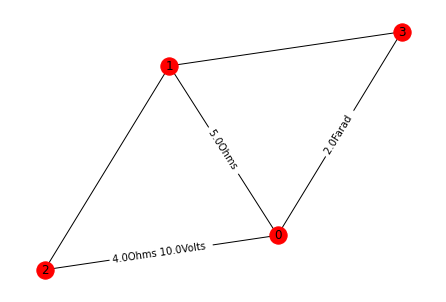

suggested_dir: 
[0]---->[1]
[0]---->[3]
[2]---->[0]
[1]---->[2]
[1]---->[3]


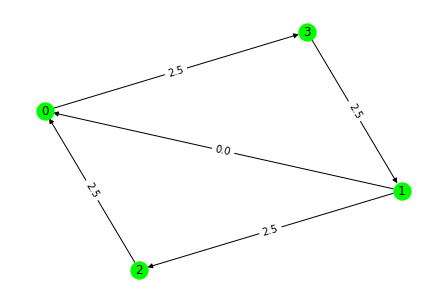

In [16]:
kg3 = circuit_parser('circuit3.txt')
plot_kirchoffgraph(kg3)
plot_kirchoffgraph_after_solving(kg3)

In [17]:
def asys(a, t, c):
    return c.dot(a)

In [18]:
# ploting dX/dt = A * X answers
# input X0,A
def solve_matrix_eq(a,x0):
    # a = np.array([[-0.5]])
    n = len(a)
    t = np.linspace(0, 10, 201)

    # x0 is the initial condition.
    # x0 = np.array([[7.0]])
    
    sol = ow.odeintw(asys, x0, t, args=(a,))

    plt.figure(1)
    plt.clf()
    colorlist = []
    for i in range(n):
        c = (rm.uniform(0, 1),rm.uniform(0, 1),rm.uniform(0, 1))
        l = 'x[0,' + str(i) + ']'
        plt.plot(t, sol[:, 0, i], color = c, label=l)


    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

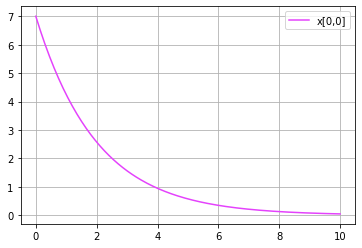

In [19]:
solve_matrix_eq(np.array([[-0.5]]),np.array([[7.0]]))

In [20]:
def circuit_type(kg):
    contain_self  = False
    contain_capacitor = False
    svals = nx.get_edge_attributes(kg3,'self').values()
    cvals = nx.get_edge_attributes(kg3,'capacitor').values()
    for sval in svals:
        if not sval == 0 :
           contain_self = True
    for cval in cvals:
        if not cval == 0 :
           contain_capacitor = True
    if not contain_self and not contain_capacitor :
        return 'Ordinary'
    if not contain_self and contain_capacitor :
        return 'RC'
    if contain_self and not contain_capacitor :
        return 'RL'
    if contain_self and contain_capacitor :
        return 'RLC'

In [21]:
circuit_type(kg3)

'RC'